## テクニカル分析

テクニカル分析というのは、

データから指標を作り、その指標と現在の値との関係を元に、将来を予測するもの
（と私は考えています）

指標とは、[Wikipedia](https://ja.wikipedia.org/wiki/%E6%8C%87%E6%A8%99)先生によると、**物事を判断したり評価したりするための目じるしとなるもの**です。（なるほど！)


### トレンド系

+ 移動平均
+ ボリンジャーバンド
+ モメンタム
+ HLバンド


### オシレーター系

+ RSI
+ MACD
+ 株価カイリ率（1）



In [16]:
%matplotlib inline
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import talib as ta

stock0 = "/tmp/7201_2018.csv"
stock1 = "/tmp/6758_2018.csv"
stock2 = "/tmp/3436_2018.csv"
stock3 = "/tmp/8306_2018.csv"

df_stock0 = pd.read_csv(stock0, skiprows=[0], encoding='shift-jis', index_col="日付", parse_dates=True)
df_stock1 = pd.read_csv(stock1, skiprows=[0], encoding='shift-jis', index_col="日付", parse_dates=True)
df_stock2 = pd.read_csv(stock2, skiprows=[0], encoding='shift-jis', index_col="日付", parse_dates=True)
df_stock3 = pd.read_csv(stock3, skiprows=[0], encoding='shift-jis', index_col="日付", parse_dates=True)

df_stock_list = [df_stock0, df_stock1, df_stock2, df_stock3,]
stock_name_list = ["NISSAN", "SONY", "SUMCO", "MUFG",]

all_data = pd.concat(df_stock_list, 
                    keys=stock_name_list,
                    names=['Ticker', 'Date'])

df_close = all_data["終値調整値"].reset_index().pivot('Date', 'Ticker', '終値調整値')


In [5]:
## 移動平均：当日から過去N日間の平均を毎日取得する。N日間を window と呼ぶ
df_close.head()

Ticker,MUFG,NISSAN,SONY,SUMCO
Date,,,,
2018-01-04,847.1,1134.0,5279.0,2996.0
2018-01-05,866.8,1149.0,5464.0,2989.0
2018-01-09,863.4,1156.5,5612.0,3100.0
2018-01-10,876.8,1156.5,5591.0,3070.0
2018-01-11,881.9,1157.5,5584.0,2967.0


In [12]:
# [pandas.DataFrame.rolling — pandas 0.23.4 documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html)
# を使う
# pandas.core.window.Rollingインスタンスを返す
# window=5 を渡して５日毎の束を持つインスタンスを作る
df_close.rolling(window=5)

Rolling [window=5,center=False,axis=0]

In [19]:
## 各Windowで平均を出す
df_close.rolling(window=5).mean().head(10)

Ticker,MUFG,NISSAN,SONY,SUMCO
Date,,,,
2018-01-04,NaN,NaN,NaN,NaN
2018-01-05,NaN,NaN,NaN,NaN
2018-01-09,NaN,NaN,NaN,NaN
2018-01-10,NaN,NaN,NaN,NaN
2018-01-11,867.20,1150.7,5506.0,3024.4
2018-01-12,872.40,1153.6,5555.2,3015.4
2018-01-15,876.80,1153.8,5555.0,3007.2
2018-01-16,881.98,1153.4,5527.4,2995.2
2018-01-17,882.80,1152.0,5501.0,3002.2


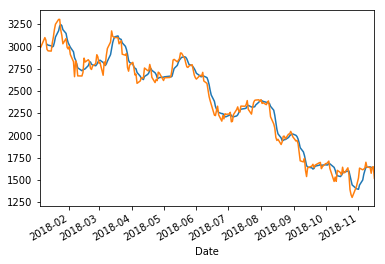

In [22]:
df_close.rolling(window=5).mean()["SUMCO"].plot()
df_close["SUMCO"].plot()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f38341100b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3833c423c8>]], dtype=object)

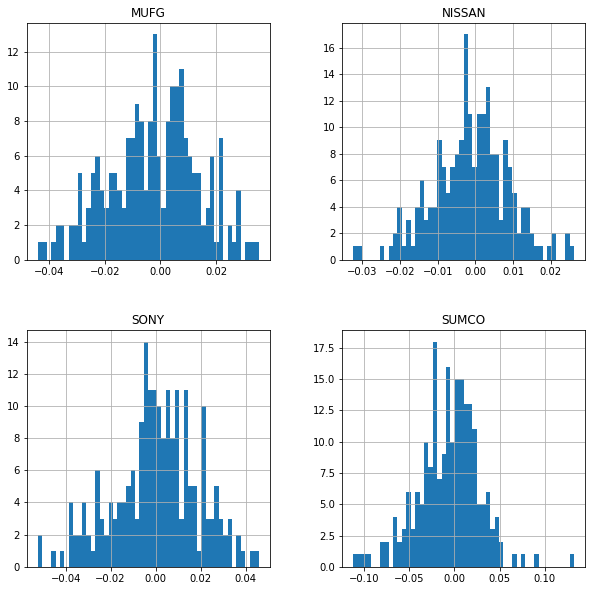

In [28]:
## 移動平均は過去ｎ日間の平均をつかった指標。
## 例えば
## 過去n日と比べて今日の終値が大きく外れていれば、「平均の方にもどるんじゃない？」と予想して逆張りしたり、
## 終値が移動平均より上にある間は買い持ちして下にある間は売り持ちする
## といったことに使ったりしているようです（やったことないけど）

## 過去n日と比べて今日の終値が大きく外れている。
## ?% 外れている.

df_ma5 = df_close.rolling(window=5).mean()
(df_close / df_ma5 - 1).hist(bins=50, figsize=(10,10))

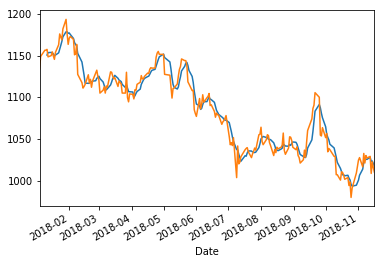

In [29]:
##５日移動平均だを見ると、NISSANは±0.02以上差ができた場合は、異常値なのではないか？
## と疑いを持つとします。
## (ヒストグラムの形がほかに比べてキレイという理由でNISSANを選び、
## そのなかで、±0.02以上がファットているに見えるから)

df_close.rolling(window=5).mean()["NISSAN"].plot()
df_close["NISSAN"].plot()

In [77]:
##では、0.02以上になったら売り持ちし、−0.02以上になったら買い持ち、それぞれ10日持ったらポジションをクローズするシュミレーションをしてみましょう

def simulation1(df_close, symbol_name="NISSAN", window=5, thred=0.02, hold=10):
    """
    symbol_name 
    """
    df_ma = df_close.rolling(window=window).mean()
    df_diff = df_close / df_ma - 1

    df = pd.DataFrame({
        "CLOSE":df_close[symbol_name], 
         "MA":df_ma[symbol_name],
         "DIFF":df_diff[symbol_name]})

    df["long flag"] = df["DIFF"] < thred * -1
    df["short flag"] = df["DIFF"] > thred

    ## 注意：ここは同じ row に未来のReturnが入っている状態
    df["day_return"] = df["CLOSE"] / df["CLOSE"].shift(-1) - 1
    
    longs = df[df["long flag"]].index
    shorts = df[df["short flag"]].index
    
    for date in longs:
        df.loc[date:].head(hold)["long flag"]=True
    for date in shorts:
        df.loc[date:].head(hold)["short flag"]=True
        
    cumsum = (df["day_return"] * df["long flag"] + df["day_return"] * df["short flag"]*-1 ).cumsum()
    return cumsum 


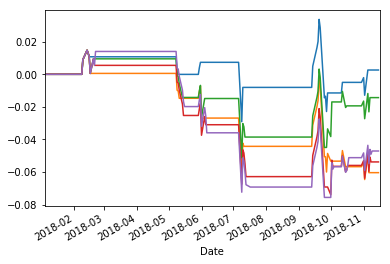

In [81]:
## 儲からない
simulation1(df_close, ).plot()


In [67]:
## 上にある間は買い持ち、下にある間は売り持ち

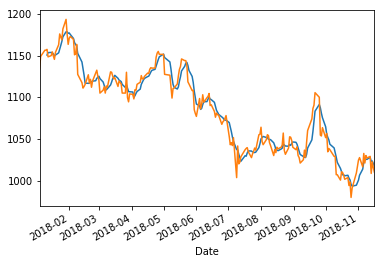

In [82]:
df_close.rolling(window=5).mean()["NISSAN"].plot()
df_close["NISSAN"].plot()

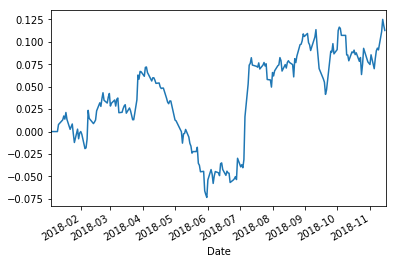

In [94]:
def simulation2(df_close, symbol_name="NISSAN", window=5):
    s_ma = df_close[symbol_name].rolling(window=window).mean()
    s_long = df_close[symbol_name] > s_ma 
    s_short = df_close[symbol_name] < s_ma
    s_return = df_close[symbol_name] / df_close[symbol_name].shift(-1) - 1 
    s_simulation = s_return * s_long + s_return * s_short * -1 
    
    return s_simulation

simulation2(df_close).cumsum().plot()
    

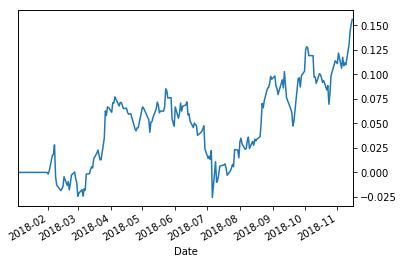

In [103]:
simulation2(df_close,window=20).cumsum().plot(secondary_y=True)